<a href="https://colab.research.google.com/github/travislatchman/Name-Entity-Recognition-using-BioGPT/blob/main/NamedEntityRecognition_BioGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name Entity Recognition (NER) to find adverse drug reaction entities


Purpose


*   To introduce Natural Language Processing (NLP) techniques.
*   To introduce Named Entity Recognition (NER) as a subfield of NLP.
*   To intoduce hugging face, an excellent resource of models and code for NLP problems.
*   To learn to use and fine-tune various NLP models from hugging face.
*   To understand the philosophy behind NLP-NER models.
*   To learn how to use tokenizers (or how to obtain word embeddings.)
<!-- *   To compare and contrast the difference between various pre-trained NLP models for NER. -->
*   To learn how to use pre trained NLP models and adapt them for specific e tasks (medical, in our case.)



***Information Extraction*** (IE) on biomedical documents is gaining steam recently, thanks to wide availability of biomedical documents and pre-trained models such as transformers.

In the two main branches of pre-trained transformer-based language models in general language fields, namely BERT (Bidirectional Encoder Representations from Transformers, and its variants) and GPT (Generative Pre-trained Transformer, and its variants), the first branch has been widely studied in the biomedical field, such as BioBERT and PubMedBERT. Although they have achieved great success in various discriminative downstream biomedical tasks, their application scope is limited due to the lack of generative ability . In this lab, we will focus on GPT models.

These models learn contextualized word embeddings.
When deploying such pre-trained models on a different domain, they usually need to be fine-tuned to overcome the shift in the word distribution.

One particular application, in the context of pharmacovigilance, is Named Entity Recognition (NER). We want to extract Adverse Drug Reaction (ADR) labels from the drug descriptions.

In this lab, we pursue NER on *drug label* documents on dataset called TAC 2017 (https://bionlp.nlm.nih.gov/tac2017adversereactions/).

***Named Entity Recognition*** (NER) labels sequences of words in a text which are the names of things, such as person and company names, or gene and protein names. We are essentially interested in finding the locations of words which describe an "adverse reaction" like allergy, ache, etc.

NERs have a special way of encoding their labels. Inputs are in the form of chunks of words (usually sentences) and various schemes of encoding labels are used like BIO, BILOU etc. In this lab we will be using the [BIO scheme](https://natural-language-understanding.fandom.com/wiki/Named_entity_recognition) of encoding labels.




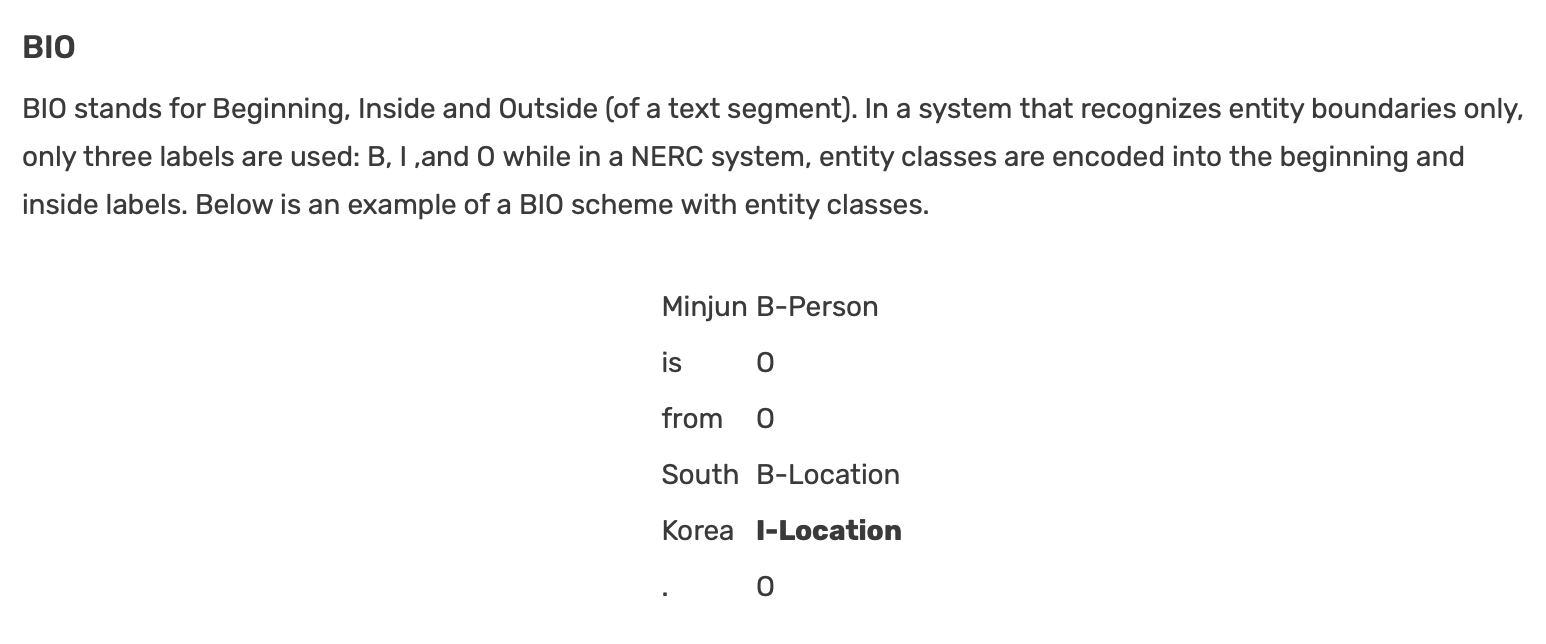

We will use BioGPT (generative pre-trained transformer for biomedical text generation and mining) and make use of its associated open-source code [Code](https://github.com/microsoft/BioGPT), AND the instruction in Hugging Face :https://huggingface.co/docs/transformers/model_doc/biogpt  

BioGPT is a pre-trained language model for text mining and generation for biomedical domain research based on GPT-2. It is a type of generative language model that has been trained on millions of previously published biomedical research articles. This means BioGPT can perform downstream tasks such as answering questions, extracting relevant data, and generating text relevant to biomedical literature.

It is highly recommended to go through the original paper at https://pubmed.ncbi.nlm.nih.gov/36156661/  since there are many details to *BioGPT* that are interesting.

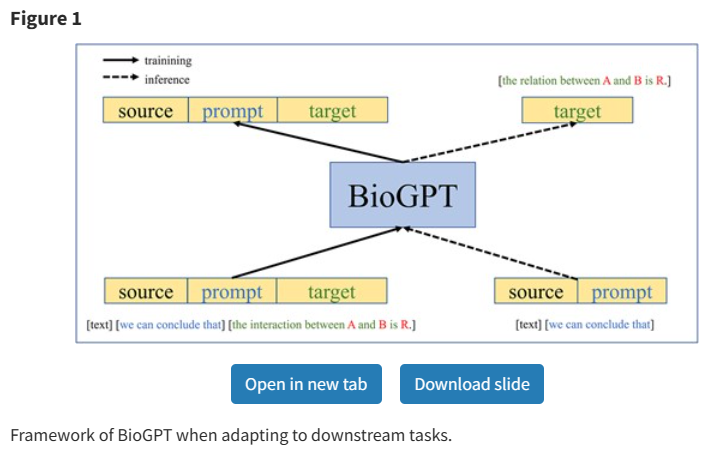

***Hugging Face 🤗*** provides open-source NLP technology for:


- "NLP researchers and educators seeking to use/study/extend large-scale transformers models"
- "hands-on practitioners who want to fine-tune those models and/or serve them in production"
- "engineers who just want to download a pretrained model and use it to solve a given NLP task."

It is recommended to go through the documenation and course of Hugging Face (https://huggingface.co/course/chapter0/1?fw=pt) which answer most of your question about implemnting NLP models in this lab.

Notes:
1. **Do not forget to select GPU runtime.**
2. Try to ensure you set up saving your models on google drive or hugging face git to ensure your training time doesnt get wasted in case of a colab crash.
3. When downloading hugging face models, make sure you understand whether it is stored in pytorch format and make changes in your code accordingly to make it run accordingly.


## Task 0 (Data download and preparation)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# get required libraries and repos (repositories)
import os
import math
from shutil import copyfile
from copy import copy
import torch
import numpy as np
import pandas as pd

!git clone https://github.com/AnthiS/MasterThesis_DS.git
!pip install datasets transformers[sentencepiece]
!apt install git-lfs
!pip install sacremoses
!pip install seqeval
!pip install evaluate
!pip install accelerate

Cloning into 'MasterThesis_DS'...
remote: Enumerating objects: 201, done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 201
Receiving objects: 100% (201/201), 2.68 MiB | 6.15 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
# Import required libraries
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

## TASK 1: Introduction to Hugging Face NLP NER Modeling.



The NLP models that we are going to use work in two steps:

1. **Tokenizers** (https://huggingface.co/course/chapter2/4?fw=pt): "Tokenizers are one of the core components of the NLP pipeline. They serve one purpose: to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data."
2. **Transformer Models** (https://huggingface.co/course/chapter2/3?fw=pt): NLP problems are generally solved using Transformer models. "Transformer models are usually very large. With millions to tens of billions of parameters, and are trained for long periods of time on powerful computers. They have been trained on large amounts of raw text in a self-supervised fashion. This type of model develops a statistical understanding of the language it has been trained on, but it’s not very useful for specific practical tasks. Because of this, the general pretrained model then goes through a process of transfer learning. During this process, the model is fine-tuned in a supervised way — that is, using human-annotated labels — on a given task."



---


NLP has a number of different applications but one of the most common one is **Token Classification**. This is what we will be doing in this lab. We will be following the Token Classification example tutorial closely for this task: https://huggingface.co/course/en/chapter7/2?fw=pt using Pytorch. Please go through this in detail and feel free to borrow code from this tutorial but make sure you understand all the steps in the code as you borrow them because we will be modifying things in order to complete the later tasks.

Token classification is a "generic task that encompasses any problem that can be formulated as “attributing a label to each token in a sentence,” such as, Named entity recognition (NER), finding the entities (such as persons, locations, or organizations) in a sentence. This can be formulated as attributing a label to each token by having one class per entity and one class for “no entity.”"


Lets begin by building a very simple NLP pipeline for Named Entity Recognition (NER). This will get you familiar with the hugging face program structure to perform NLP tasks. Constuct NLP pipeline using `dslim/bert-base-NER` in the Hugging Face repository and run a test on the given test sentence. Use both tokenizer and model from pretrained checkpoints of `dslim/bert-base-NER` to build your hugging face pipeline.


In [ ]:
# YOUR CODE GOES HERE
# Import required libraries
#from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load the pretrained tokenizer and model from the checkpoint
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# Create the NLP pipeline using the tokenizer and model
nlp = pipeline("ner", model=model, tokenizer=tokenizer)


In [ ]:
# Predict the result to sentence.
example = """"My name is Wolfgang and I live in Berlin"""

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-PER', 'score': 0.99911743, 'index': 5, 'word': 'Wolfgang', 'start': 12, 'end': 20}, {'entity': 'B-LOC', 'score': 0.9996369, 'index': 10, 'word': 'Berlin', 'start': 35, 'end': 41}]


### Expected output:

[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]

#### **Question** List and explain the various labels in the `dslim/bert-base-NER` model and their corresponding ids.

In [ ]:
# YOUR CODE GOES HERE
label_list = model.config.id2label
print(label_list)


{0: 'O', 1: 'B-MISC', 2: 'I-MISC', 3: 'B-PER', 4: 'I-PER', 5: 'B-ORG', 6: 'I-ORG', 7: 'B-LOC', 8: 'I-LOC'}


1. O (Outside): A token that does not represent an entity or belongs to any entity class.
2. B-MISC (Beginning - Miscellaneous): The first token of an entity that does not belong to any specific class (e.g., Person, Organization, or Location).
3. I-MISC (Inside - Miscellaneous): A token inside an entity that is not part of any specific class.
4. B-PER (Beginning - Person): The first token of a person's name.
5. I-PER (Inside - Person): A token inside a person's name.
6. B-ORG (Beginning - Organization): The first token of an organization's name.
7. I-ORG (Inside - Organization): A token inside an organization's name.
8. B-LOC (Beginning - Location): The first token of a location name.
9. I-LOC (Inside - Location): A token inside a location name.

## TASK 2: Fine-turn your own BioGPT in Hugging Face for NER.

The purpose of this task is to teach you how to fine-tune a hugging face model for token classfication using the internal [hugging face datasets](https://huggingface.co/course/chapter5/1?fw=tf). This task is more approachable because the datasets from hugging face are already in the right hugging face data structure for use in the hugging face models. In the later tasks you will be utilizing a custom dataset and pre-processing it in the hugging face data structure format to fine-tune your hugging face models.


---




Use `ncbi-disease`dataset from the internal hugging face repository to fine-tune your own bioGPT in Hugging Face. Use a pre-trained `microsoft/biogpt` model as your GPT model. In `ncbi-disease`, three labels for a token are provided as: ['O','B-Disease','I-Disease'], what we need to do is to finetune BioGPT for this BIO NER task.

Hugging Face is a great platform for sharing your NLP models with the community. This allows for saving energy wasted to train similar models over and over again and helps reduce the carbon footprint due to modern AI modeling.


**In this task, make sure to upload your model** to hugging face git as explained in the [Token Classification example tutorial](https://huggingface.co/course/chapter7/2?fw=pt) and https://huggingface.co/transformers/v4.10.1/model_sharing.html . You will have to make a hugging face account for this.


***CODING SUGGESTION:***  *Feel free to make this fine-tune step a function that takes in a dataset, a model name and a few parameters so you can reuse this in the later tasks without having to copy long lines of codes over and over again.*

***OPTIMIZATION SUGGESTION:***  *Uploading models to hugging face git takes a long time. Try to make this an optional parameter in your fine-tune function so you dont waste time uploading your model in later tasks everytime you call your function.*

### instantiate tokenizer BioGpt

In [ ]:
# redefine your tokenizer for BioGPT
base_model_name = "microsoft/biogpt";
from transformers import BioGptTokenizer
from transformers import GPT2ForTokenClassification
tokenizer = BioGptTokenizer.from_pretrained(base_model_name)

In [ ]:
# load dataset
from datasets import load_dataset
raw_datasets = load_dataset("ncbi_disease")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5433 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/924 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

Dataset ncbi_disease downloaded and prepared to /root/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})


In [ ]:
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)

In [ ]:
label_names = ner_feature.feature.names
label_names

['O', 'B-Disease', 'I-Disease']

### DATASET PRACTICE

In [ ]:
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

Identification of APC2 , a homologue of the adenomatous polyposis coli      tumour    suppressor . 
O              O  O    O O O         O  O   B-Disease   I-Disease I-Disease I-Disease O          O 


#### tokenizer outputs,

In [ ]:
# inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
# inputs

{'input_ids': [2, 3655, 5, 388, 33132, 7, 14, 11813, 5, 6, 16958, 14396, 1011, 1529, 3770, 4], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
inputs = tokenizer(raw_datasets["train"][1]["tokens"], is_split_into_words=True, return_special_tokens_mask=True)
inputs

{'input_ids': [2, 18, 16958, 14396, 1011, 12, 7487, 11, 1529, 81, 3770, 80, 433, 6, 6615, 4234, 609, 23, 2442, 14, 324, 15, 5764, 2517, 617, 19189, 12, 16857, 81, 19189, 11, 7, 4233, 10, 26, 19859, 3147, 8, 9459, 1191, 1194, 13150, 4], 'special_tokens_mask': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
inputs['input_ids']

[2, 3655, 5, 388, 33132, 7, 14, 11813, 5, 6, 16958, 14396, 1011, 1529, 3770, 4]

In [ ]:
# for token_id in inputs['input_ids'] :
#   token = tokenizer.convert_ids_to_tokens(token_id)
#   print(token)

tokenizer.convert_ids_to_tokens(inputs['input_ids'])

['</s>',
 'Identification</w>',
 'of</w>',
 'A',
 'PC2</w>',
 ',</w>',
 'a</w>',
 'homologue</w>',
 'of</w>',
 'the</w>',
 'adenomatous</w>',
 'polyposis</w>',
 'coli</w>',
 'tumour</w>',
 'suppressor</w>',
 '.</w>']

In [ ]:
inputs['input_ids']

[2,
 18,
 16958,
 14396,
 1011,
 12,
 7487,
 11,
 1529,
 81,
 3770,
 80,
 433,
 6,
 6615,
 4234,
 609,
 23,
 2442,
 14,
 324,
 15,
 5764,
 2517,
 617,
 19189,
 12,
 16857,
 81,
 19189,
 11,
 7,
 4233,
 10,
 26,
 19859,
 3147,
 8,
 9459,
 1191,
 1194,
 13150,
 4]

In [ ]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'])

['</s>',
 'The</w>',
 'adenomatous</w>',
 'polyposis</w>',
 'coli</w>',
 '(</w>',
 'APC</w>',
 ')</w>',
 'tumour</w>',
 '-</w>',
 'suppressor</w>',
 'protein</w>',
 'controls</w>',
 'the</w>',
 'Wnt</w>',
 'signalling</w>',
 'pathway</w>',
 'by</w>',
 'forming</w>',
 'a</w>',
 'complex</w>',
 'with</w>',
 'glycogen</w>',
 'synthase</w>',
 'kinase</w>',
 '3beta</w>',
 '(</w>',
 'GSK</w>',
 '-</w>',
 '3beta</w>',
 ')</w>',
 ',</w>',
 'ax',
 'in</w>',
 '/</w>',
 'conduc',
 'tin</w>',
 'and</w>',
 'bet',
 'ac',
 'at',
 'enin</w>',
 '.</w>']

In [ ]:
len(raw_datasets["train"][0]["ner_tags"])

14

In [ ]:
len(inputs['input_ids'])

16

### printing examples


In [ ]:
# Print some examples from the dataset
for i in range(5):
    print(f"Example {i + 1}:")
    print("Tokens:", raw_datasets["train"][i]["tokens"])
    print("NER Tags:", raw_datasets["train"][i]["ner_tags"])
    print()

Example 1:
Tokens: ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.']
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]

Example 2:
Tokens: ['The', 'adenomatous', 'polyposis', 'coli', '(', 'APC', ')', 'tumour', '-', 'suppressor', 'protein', 'controls', 'the', 'Wnt', 'signalling', 'pathway', 'by', 'forming', 'a', 'complex', 'with', 'glycogen', 'synthase', 'kinase', '3beta', '(', 'GSK', '-', '3beta', ')', ',', 'axin', '/', 'conductin', 'and', 'betacatenin', '.']
NER Tags: [0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 3:
Tokens: ['Complex', 'formation', 'induces', 'the', 'rapid', 'degradation', 'of', 'betacatenin', '.']
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 4:
Tokens: ['In', 'colon', 'carcinoma', 'cells', ',', 'loss', 'of', 'APC', 'leads', 'to', 'the', 'accumulation', 'of', 'betacatenin', 'in', 'the', 'nucleus', ',', 'whe

### align_label_with_tokens and tokenize_and_align_labels with custom_word_id



---

HINTS:

1. Define your own align_labels_with_tokens and tokenize_and_align_labels according to the instruction provided (revisions are needed to fit our tokenizer) For the tokenizer of BioGPT, as there is no `word_ids()`, you need to write your OWN equivalent function.

2. You need to prepare your dataset by replacing the old labels with aligned labels, from raw_datasets we will construct a tokenized_datasets.

3. Load your pre-trained BioGpt model using checkpoint 'microsoft/biogpt' and class GPT2ForTokenClassification. BioGPT for token classification is not yet integrated as a well-packed class in HuggingFace.So here we instantiate a model of gpt2 token classifier.

4. It is OK to just use the Trainer API as long as it could work. Training parameters like criterion function are not limited.

In [ ]:
def custom_word_ids(sentence, tokenizer):
    tokenized_sentence = tokenizer(sentence, return_special_tokens_mask=True)
    word_ids = []
    current_word_id = 0

    for is_special_token in tokenized_sentence['special_tokens_mask']:
        if is_special_token:
            word_ids.append(None)
        else:
            word_ids.append(current_word_id)
            current_word_id += 1

    return word_ids


In [ ]:

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else (labels[word_id] if word_id < len(labels) else 0)
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id] if word_id < len(labels) else 0
            # If the label is B-Disease, we change it to I-Disease
            if label == 1:  # 1 is the index of B-Disease
                label = 2  # 2 is the index of I-Disease
            new_labels.append(label)

    return new_labels


In [ ]:
def tokenize_and_align_labels(examples):
    text_sentences = [' '.join(tokens) for tokens in examples['tokens']]
    tokenized_inputs = tokenizer(text_sentences, padding="max_length", truncation=True, is_split_into_words=False)

    labels = []
    for i, label in enumerate(examples['ner_tags']):
        # Get word_ids using the custom_word_ids function
        word_ids = custom_word_ids(text_sentences[i], tokenizer)

        # Align the labels with the tokens using the new align_labels_with_tokens function
        aligned_labels = align_labels_with_tokens(label, word_ids)
        labels.append(aligned_labels)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs


output several examples from tokenized input and check if the length of the labels is the same length of the tokenized token

### tokenize dataset

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/5433 [00:00<?, ? examples/s]

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

### Print examples from Tokenized Dataset after mapping

In [ ]:
# Print some examples from the dataset
for i in range(5):
    print(f"Example {i + 1}:")
    print("Tokens:", tokenized_datasets["train"][i]["tokens"])
    print("NER Tags:", tokenized_datasets["train"][i]["ner_tags"])
    print("labels:", tokenized_datasets["train"][i]["labels"])
    print()

Example 1:
Tokens: ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.']
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]
labels: [-100, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0]

Example 2:
Tokens: ['The', 'adenomatous', 'polyposis', 'coli', '(', 'APC', ')', 'tumour', '-', 'suppressor', 'protein', 'controls', 'the', 'Wnt', 'signalling', 'pathway', 'by', 'forming', 'a', 'complex', 'with', 'glycogen', 'synthase', 'kinase', '3beta', '(', 'GSK', '-', '3beta', ')', ',', 'axin', '/', 'conductin', 'and', 'betacatenin', '.']
NER Tags: [0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
labels: [-100, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 3:
Tokens: ['Complex', 'formation', 'induces', 'the', 'rapid', 'degradation', 'of', 'betacatenin', '.']
NER Tags: [0,

In [ ]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 941
    })
})


In [ ]:
inputs = tokenizer(tokenized_datasets["train"][0]["tokens"], is_split_into_words=True)

In [ ]:
inputs

{'input_ids': [2, 3655, 5, 388, 33132, 7, 14, 11813, 5, 6, 16958, 14396, 1011, 1529, 3770, 4], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# # Load the pre-trained model and configure it for token classification
# num_labels = len(tokenizer.get_vocab())
# model = GPT2ForTokenClassification.from_pretrained(base_model_name, num_labels=num_labels)

You are using a model of type biogpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/biogpt were not used when initializing GPT2ForTokenClassification: ['biogpt.layers.13.fc1.bias', 'biogpt.layers.7.final_layer_norm.bias', 'biogpt.layers.2.fc1.bias', 'biogpt.layers.16.self_attn.out_proj.bias', 'biogpt.layers.8.self_attn.k_proj.bias', 'biogpt.layers.20.self_attn.out_proj.weight', 'biogpt.layers.7.self_attn.out_proj.bias', 'biogpt.layers.15.self_attn.out_proj.bias', 'biogpt.layers.14.final_layer_norm.weight', 'biogpt.layers.15.self_attn.out_proj.weight', 'biogpt.layers.11.fc1.weight', 'biogpt.layers.18.self_attn_layer_norm.weight', 'biogpt.layers.11.self_attn.out_proj.weight', 'biogpt.layers.3.self_attn.k_proj.bias', 'biogpt.layers.2.self_attn.q_proj.bias', 'biogpt.layers.11.fc2.bias', 'biogpt.layers.5.self_attn.q_proj.bias', 'biogpt.layers.17.fc1.bias', 'biogpt.layers.6.se

In [ ]:
# model = AutoModelForTokenClassification.from_pretrained(
#     model_checkpoint,
#     id2label=id2label,
#     label2id=label2id,
# )

### Model

In [ ]:
model = GPT2ForTokenClassification.from_pretrained(base_model_name, num_labels=3)

You are using a model of type biogpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at microsoft/biogpt were not used when initializing GPT2ForTokenClassification: ['biogpt.layers.2.self_attn.q_proj.bias', 'biogpt.layers.13.self_attn.v_proj.weight', 'biogpt.layers.18.self_attn.k_proj.weight', 'biogpt.layers.14.fc2.weight', 'biogpt.layers.15.self_attn.q_proj.weight', 'biogpt.layers.16.final_layer_norm.weight', 'biogpt.layers.15.final_layer_norm.bias', 'biogpt.layers.8.fc1.weight', 'biogpt.layers.20.self_attn.k_proj.weight', 'biogpt.layers.15.self_attn.k_proj.bias', 'biogpt.layers.5.self_attn.out_proj.weight', 'biogpt.layers.18.self_attn.q_proj.weight', 'biogpt.layers.5.self_attn.k_proj.bias', 'biogpt.layers.17.self_attn.q_proj.bias', 'biogpt.layers.22.self_attn.out_proj.weight', 'biogpt.layers.19.self_attn.q_proj.weight', 'biogpt.layers.14.self_attn.k_proj.bias', 'biogpt.layers.11.self_attn_layer_norm.bias', 'biogpt.layers.11.fc1.weight', 'biogpt.layers.4.self_attn_layer_norm.bias', 'biogpt.layers.20.fc1.weight', 'biogpt.layers.22.s

### HUB - HuggingFace (model.save_pretrained("BioGPT") and trainer.save_pretrained("BioGPT")

In [ ]:
model.save_pretrained("BioGPT")
tokenizer.save_pretrained("BioGPT")

('BioGPT/tokenizer_config.json',
 'BioGPT/special_tokens_map.json',
 'BioGPT/vocab.json',
 'BioGPT/merges.txt',
 'BioGPT/added_tokens.json')

### TRAINER API

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
import evaluate

metric = evaluate.load("seqeval")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir="./logs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.260000,0.236217,0.230263,0.044473,0.074547,0.931425
2,0.197900,0.210081,0.281155,0.235070,0.256055,0.937726


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.260000,0.236217,0.230263,0.044473,0.074547,0.931425
2,0.197900,0.210081,0.281155,0.235070,0.256055,0.937726
3,0.183000,0.217932,0.311450,0.259212,0.282940,0.939321


TrainOutput(global_step=4077, training_loss=0.2248220843721436, metrics={'train_runtime': 3289.3754, 'train_samples_per_second': 4.955, 'train_steps_per_second': 1.239, 'total_flos': 3.0274093173970944e+16, 'train_loss': 0.2248220843721436, 'epoch': 3.0})

### OLD TRAINING, BUT KEEP FOR DOCUMENTATION/RECORDS

In [ ]:
# trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.009700
1000,0.004600
1500,0.003600
2000,0.002400
2500,0.001800
3000,0.001500


Step,Training Loss
500,0.009700
1000,0.004600
1500,0.003600
2000,0.002400
2500,0.001800
3000,0.001500
3500,0.000900
4000,0.001100


TrainOutput(global_step=4077, training_loss=0.0031592405643537987, metrics={'train_runtime': 3150.7953, 'train_samples_per_second': 5.173, 'train_steps_per_second': 1.294, 'total_flos': 3.0274093173970944e+16, 'train_loss': 0.0031592405643537987, 'epoch': 3.0})



---



## TASK 3: Analyze your GPT results using `seqeval`.

The traditional framework used to evaluate token classification prediction is [seqeval](https://github.com/chakki-works/seqeval). As its GitHub suggests, "`seqeval` is a Python framework for sequence labeling evaluation. seqeval can evaluate the performance of chunking tasks such as named-entity recognition, part-of-speech tagging, semantic role labeling and so on."

The implementation of this task is also explained in the [Token Classification example tutorial](https://huggingface.co/course/chapter7/2?fw=tf) in the Metrics section . Please go through it in detail and feel free to borrow code from this tutorial but make sure you understand all the steps in the code as you borrow them because we will be needing a close understanding of this step in order to finish the later steps.

Test your model's performance on the testing dataset, **by printing out the the overall_precision,overall_recall,overall_f1, and overall_accuracy,**

***CODING SUGGESTION:***  *Feel free to make this metrics step a function that takes in a test dataset, a model name and a few parameters so you can reuse this in the later tasks without having to copy long lines of codes over and over again.*



In [ ]:
# !pip install seqeval


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### trainer.evaluate()

In [ ]:
# Evaluate the model on the test dataset
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

{'eval_loss': nan, 'eval_precision': 0.2859304084720121, 'eval_recall': 0.196875, 'eval_f1': 0.23318938926588526, 'eval_accuracy': 0.930300279857802, 'eval_runtime': 59.1226, 'eval_samples_per_second': 15.916, 'eval_steps_per_second': 3.992, 'epoch': 3.0}


In [ ]:
print("Overall Precision:", results["eval_precision"])
print("Overall Recall:", results["eval_recall"])
print("Overall F1 Score:", results["eval_f1"])
print("Overall Accuracy:", results["eval_accuracy"])

Overall Precision: 0.2859304084720121
Overall Recall: 0.196875
Overall F1 Score: 0.23318938926588526
Overall Accuracy: 0.930300279857802


In [ ]:
# General evaluate(), not called specifically on test dataset
eval_results = trainer.evaluate()

In [ ]:
eval_results

{'eval_loss': 0.2179320752620697,
 'eval_precision': 0.3114503816793893,
 'eval_recall': 0.25921219822109276,
 'eval_f1': 0.2829403606102635,
 'eval_accuracy': 0.939320860399082,
 'eval_runtime': 59.6317,
 'eval_samples_per_second': 15.495,
 'eval_steps_per_second': 3.874,
 'epoch': 3.0}

In [ ]:
print("Overall Precision:", eval_results["eval_precision"])
print("Overall Recall:", eval_results["eval_recall"])
print("Overall F1 Score:", eval_results["eval_f1"])
print("Overall Accuracy:", eval_results["eval_accuracy"])

Overall Precision: 0.3114503816793893
Overall Recall: 0.25921219822109276
Overall F1 Score: 0.2829403606102635
Overall Accuracy: 0.939320860399082


### seqeval.metrics

In [ ]:
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# Get predictions
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

In [ ]:
# Remove ignored index (-100)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

In [ ]:
# Compute seqeval metrics
print("Precision:", precision_score(true_labels, true_predictions))
print("Recall:", recall_score(true_labels, true_predictions))
print("F1-score:", f1_score(true_labels, true_predictions))
print("Accuracy:", accuracy_score(true_labels, true_predictions))

Precision: 0.2859304084720121
Recall: 0.196875
F1-score: 0.23318938926588526
Accuracy: 0.930300279857802


In [ ]:
import evaluate
seqeval = evaluate.load('seqeval')

In [ ]:
# Calculate the metric using the predictions and true labels
results = seqeval.compute(predictions=true_predictions, references=true_labels)

# Print the results
print(results)

{'Disease': {'precision': 0.2859304084720121, 'recall': 0.196875, 'f1': 0.23318938926588526, 'number': 960}, 'overall_precision': 0.2859304084720121, 'overall_recall': 0.196875, 'overall_f1': 0.23318938926588526, 'overall_accuracy': 0.930300279857802}


## TASK 4: Use your checkpoint directly from hugging face git

As mentioned previously, Hugging Face is a great platform for sharing your NLP models with the community as well as using NLP models trained by other members of the community. Use the model you trained in the previous step and saved onto your hugging face git. This will teach you how to utilize models from the community quickly for your own purposes. This task can also be understood in detail in the "Using the fine-tuned model" section of the [Token Classification example tutorial](https://huggingface.co/course/chapter7/2?fw=tf).

In [ ]:
from transformers import pipeline

In [ ]:
#model_checkpoint = "xxx" # Replace this with your own checkpoint
# Move the model to CPU
model = model.to('cpu')

token_classifier = pipeline(
    "token-classification", model=model, tokenizer = tokenizer, aggregation_strategy="simple")
token_classifier("That patient had a neurological disorder. He also reported fever.")

[{'entity_group': 'LABEL_0',
  'score': 0.98410076,
  'word': 'That patient had a',
  'start': None,
  'end': None},
 {'entity_group': 'LABEL_1',
  'score': 0.8015009,
  'word': 'neurological',
  'start': None,
  'end': None},
 {'entity_group': 'LABEL_2',
  'score': 0.5857765,
  'word': 'disorder',
  'start': None,
  'end': None},
 {'entity_group': 'LABEL_0',
  'score': 0.95252085,
  'word': '. He also reported',
  'start': None,
  'end': None},
 {'entity_group': 'LABEL_2',
  'score': 0.50239956,
  'word': 'fever',
  'start': None,
  'end': None},
 {'entity_group': 'LABEL_0',
  'score': 0.9991634,
  'word': '.',
  'start': None,
  'end': None}]

Test your pipeline on the test phrase below to see how well your bioGPT performs.

In [ ]:
test_phrase = """
Multiple sclerosis (MS) is a chronic autoimmune disease that affects the central nervous system.
It is characterized by the inflammation and damage of myelin, the protective covering of nerve fibers.
MS symptoms vary widely and can include fatigue, weakness, numbness, vision problems, and cognitive impairment.
Diagnosis is typically made through a combination of clinical evaluation, imaging tests, and laboratory analysis.
Although there is currently no cure for MS, treatments such as immunosuppressive drugs and physical therapy can help manage symptoms and slow disease progression.
"""


In [ ]:
result = token_classifier(test_phrase)
print(result)

[{'entity_group': 'LABEL_0', 'score': 0.9843525, 'word': 'Multiple sclerosis (MS) is a', 'start': None, 'end': None}, {'entity_group': 'LABEL_1', 'score': 0.6964662, 'word': 'chronic', 'start': None, 'end': None}, {'entity_group': 'LABEL_2', 'score': 0.7000337, 'word': 'autoimmune disease', 'start': None, 'end': None}, {'entity_group': 'LABEL_0', 'score': 0.9576465, 'word': 'that affects the central nervous system. It is characterized by the inflammation and damage of myelin, the protective covering of nerve fibers. MS symptoms vary widely and can include fatigue, weakness, numbness, vision problems, and cognitive impairment. Diagnosis is typically made through a combination of clinical evaluation, imaging tests, and laboratory analysis. Although there is currently no cure for MS, treatments such as immunosuppressive drugs and physical therapy can help manage symptoms and slow disease progression.', 'start': None, 'end': None}]


## TASK 5: Use Custom Data in your BioGPT Hugging Face model to create Adverse Drug Reaction NER model

**The  TAC 2017 dataset**
According to the authors of the dataset, "the purpose of this TAC track is to test various natural language processing (NLP) approaches for their information extraction (IE) performance on adverse reactions found in structured product labels (SPLs, or simply "labels"). A large set of labels will be provided to participants, of which 101 will be annotated with adverse reactions. Additionally, the training labels will be accompanied by the MedDRA Preferred Terms (PT) and Lower Level Terms (LLT) of the ADRs in the drug labels. This corresponds to the primary goal of the task: to identify the known ADRs in a SPL in the form of MedDRA concepts. Participants will be evaluated by their performance on a held-out set of labeled SPLs."



We will work with only the *annotated training portion* of TAC 2017 since labels are not available for the larger unannotated portion: https://bionlp.nlm.nih.gov/tac2017adversereactions/unannotated_xml.tar.gz.Instead of directly using `train_xml.tar.gz`, we will use a pre-processed version which is split into five equal portions in the open-source code we downloaded. We will only use one of the splits in this lab. It is *bio-tagged* i.e. the tokens of drug documents are labeled as "B", "I", or "O". <br>> "B" marks the *beginning* of adverse reaction <br>> "I" denotes the *interior* of labeling (follows after the "B" tag) <br>> "O" is the *default/non-available* tag <br>Standard bio-tagging scheme is used for this. Find the splits in: `MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_i` where $i \in [1,5]$. Each split consists of four `.tsv` files: - `train.tsv`, `train_dev.tsv` (training samples)- `devel.tsv` (development samples)- `test.tsv` (test samples).

### TASK 5.1: (Exploring & Verifying Data)
Print the top 40 and bottom 40 lines of training (`train_dev.tsv`) and testing files (`test.tsv`) in the first split of data ("TAC_1"). Now write code to verify that only the following three types of labels are present in all the five splits of data: "B", "I", and "O".

### 5.1 i.) first implementation

In [ ]:
# data_directory = "MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_1"
# train_file = os.path.join(data_directory, "train_dev.tsv")
# test_file = os.path.join(data_directory, "test.tsv")

In [ ]:
# def print_lines(file_path, n):
#     with open(file_path, "r") as f:
#         lines = f.readlines()
#     print("".join(lines[:n]))
#     print("-----------")
#     print("".join(lines[-n:]))

In [ ]:
# print("Training file (train_dev.tsv):\n")
# print_lines(train_file, 40)

Training file (train_dev.tsv):

	
The	O
psychiatric	B
symptoms	I
in	O
the	O
vast	O
majority	O
of	O
patients	O
in	O
both	O
controlled	O
and	O
open-label	O
trials	O
resolved	O
within	O
7	O
days	O
of	O
discontinuation	O
of	O
POTIGA	O
.	O
	
Chickenpox	B
and	O
measles	B
,	O
for	O
example	O
,	O
can	O
have	O
a	O
more	O
serious	O
or	O
even	O

-----------
is	O
discussed	O
elsewhere	O
in	O
the	O
labeling	O
:	O
*	O
Hypotension	B
and	O
Reflex	B
Tachycardia	I
[	O
see	O
Warnings	O
and	O
Precautions	O
(	O
5.2	O
)	O
]	O
EXCERPT	O
:	O
Most	O
common	O
adverse	O
reactions	O
(	O
>	O
2	O
%	O
)	O
are	O
headache	B
,	O
nausea	B
,	O
and	O
vomiting	B
.	O



In [ ]:
# print("Test file (test.tsv):\n")
# print_lines(test_file, 40)

Test file (test.tsv):

	
Approximately	O
60	O
%	O
of	O
the	O
treated	O
patients	O
were	O
male	O
,	O
with	O
a	O
mean	O
age	O
of	O
55.1	O
years	O
.	O
	
The	O
table	O
below	O
lists	O
the	O
adverse	O
drug	O
reactions	O
that	O
occurred	O
in	O
at	O
least	O
1	O
%	O
of	O
patients	O
treated	O
with	O
Ferriprox	O

-----------
and	O
follow-up	O
testing	O
every	O
6	O
months	O
.	O
	
To	O
report	O
SUSPECTED	O
ADVERSE	O
REACTIONS	O
,	O
contactJanssen	O
Biotech	O
,	O
Inc.	O
at	O
1-800-JANSSEN	O
(	O
1-800-526-7736	O
)	O
or	O
FDA	O
at	O
1-800-FDA-1088	O
or	O
www.fda.gov/medwatch	O
.	O
	
Monitor	O
for	O
pulmonary	O
symptoms	O
and	O
bilateral	O
interstitial	O
infiltrates	O
.	O



### 5.1 Alternate Verifications

In [ ]:
def verify_labels(data_directory):
    for i in range(1, 6):
        folder = f"TAC_{i}"
        train_file = os.path.join(data_directory, folder, "train_dev.tsv")
        test_file = os.path.join(data_directory, folder, "test.tsv")
        for file in [train_file, test_file]:
            with open(file, "r") as f:
                lines = f.readlines()
            for line in lines:
                if line.strip():
                    label = line.strip().split("\t")[-1]
                    assert label in ["B", "I", "O"], f"Invalid label '{label}' found in {folder}/{file}"

In [ ]:
data_directory = "MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples"

In [ ]:
verify_labels(data_directory)


### code to verify that only the labels "B", "I", and "O" are present in all the five splits of data. will print "TAC_i split verified" for each split if it contains only the "B", "I", and "O" labels.

In [ ]:
def verify_labels(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            tokens = line.strip().split()
            if len(tokens) == 2:
                label = tokens[1]
                if label not in ["B", "I", "O"]:
                    return False
    return True

for i in range(1, 6):
    base_path = f"MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_{i}"
    train_file = f"{base_path}/train_dev.tsv"
    devel_file = f"{base_path}/devel.tsv"
    test_file = f"{base_path}/test.tsv"

    if not verify_labels(train_file) or not verify_labels(devel_file) or not verify_labels(test_file):
        print(f"Invalid label found in TAC_{i} split.")
    else:
        print(f"TAC_{i} split verified.")


TAC_1 split verified.
TAC_2 split verified.
TAC_3 split verified.
TAC_4 split verified.
TAC_5 split verified.


### 5.1 version/implementation 2

In [ ]:
data_dir = "MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_1"

In [ ]:
# Print top 40 and bottom 40 lines of train_dev.tsv and test.tsv
def print_file_content(file_path, num_lines=40):
    with open(file_path, "r") as f:
        content = f.readlines()
        print("Top {} lines:".format(num_lines))
        print("".join(content[:num_lines]))
        print("\nBottom {} lines:".format(num_lines))
        print("".join(content[-num_lines:]))

In [ ]:
print("Train_dev.tsv content:")
print_file_content(os.path.join(data_dir, "train_dev.tsv"))

Train_dev.tsv content:
Top 40 lines:
	
The	O
psychiatric	B
symptoms	I
in	O
the	O
vast	O
majority	O
of	O
patients	O
in	O
both	O
controlled	O
and	O
open-label	O
trials	O
resolved	O
within	O
7	O
days	O
of	O
discontinuation	O
of	O
POTIGA	O
.	O
	
Chickenpox	B
and	O
measles	B
,	O
for	O
example	O
,	O
can	O
have	O
a	O
more	O
serious	O
or	O
even	O


Bottom 40 lines:
is	O
discussed	O
elsewhere	O
in	O
the	O
labeling	O
:	O
*	O
Hypotension	B
and	O
Reflex	B
Tachycardia	I
[	O
see	O
Warnings	O
and	O
Precautions	O
(	O
5.2	O
)	O
]	O
EXCERPT	O
:	O
Most	O
common	O
adverse	O
reactions	O
(	O
>	O
2	O
%	O
)	O
are	O
headache	B
,	O
nausea	B
,	O
and	O
vomiting	B
.	O



In [ ]:
print("\nTest.tsv content:")
print_file_content(os.path.join(data_dir, "test.tsv"))


Test.tsv content:
Top 40 lines:
	
Approximately	O
60	O
%	O
of	O
the	O
treated	O
patients	O
were	O
male	O
,	O
with	O
a	O
mean	O
age	O
of	O
55.1	O
years	O
.	O
	
The	O
table	O
below	O
lists	O
the	O
adverse	O
drug	O
reactions	O
that	O
occurred	O
in	O
at	O
least	O
1	O
%	O
of	O
patients	O
treated	O
with	O
Ferriprox	O


Bottom 40 lines:
and	O
follow-up	O
testing	O
every	O
6	O
months	O
.	O
	
To	O
report	O
SUSPECTED	O
ADVERSE	O
REACTIONS	O
,	O
contactJanssen	O
Biotech	O
,	O
Inc.	O
at	O
1-800-JANSSEN	O
(	O
1-800-526-7736	O
)	O
or	O
FDA	O
at	O
1-800-FDA-1088	O
or	O
www.fda.gov/medwatch	O
.	O
	
Monitor	O
for	O
pulmonary	O
symptoms	O
and	O
bilateral	O
interstitial	O
infiltrates	O
.	O



In [ ]:
# Verify only "B", "I", and "O" labels are present
def verify_labels(directory):
    splits = [os.path.join(directory, f"TAC_{i}") for i in range(1, 6)]
    labels = set()
    for split in splits:
        for file in ["train_dev.tsv", "devel.tsv", "test.tsv"]:
            with open(os.path.join(split, file), "r") as f:
                content = f.readlines()
                for line in content:
                    tokens = line.strip().split()
                    if len(tokens) == 2:
                        labels.add(tokens[1])
    print("Labels present:", labels)

In [ ]:
print("\nLabels verification:")
verify_labels("MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/")


Labels verification:
Labels present: {'I', 'B', 'O'}


### TASK 5.2 : (Pre-processing the Data)

This most challenging part of utilizing a platform like Hugging Face is to pre-process the data in the right format and data structure to ensure the hugging face models can access, read and fine-tune your data perfectly and give the best results.

This hugging face tutorial page gives some direction as to how to prepare your custom dataset to be utilized in a huggin face model: https://huggingface.co/transformers/v3.2.0/custom_datasets.html. Please go through this to get some direction on how to perform this. But remember we are preparing data for a specific purpose, i.e. **Token Classification**. So your data needs to be prepared in a specific way that might be different from data preparation for other NLP tasks like Translation, Summerization, etc.

Although this task can be performed in a variety of ways, the best **suggested path** would be to closely understand the internal hugging face `ncbi dataset` used in the above example (or any internal hugging face dataset you like), and generate an exactly similar data structure that would contain data from TAC2017: `MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_1`

This would involve the following steps:

1. Read data from train and test tsv files in: `MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples/TAC_1`
2. Split train into train and validate. Use any percent split you think best.
3. Generate a data structure same as the internal hugging face `ncbi dataset` data structure containing all the TAC_1 data just extracted above.

Utilize `datasets.DatasetDict` function to get exact data structure as ncbi data structure




In [ ]:
from datasets import load_dataset
ncbi_datasets = load_dataset("ncbi_disease")
ncbi_datasets

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

Also remember that in the `ncbi_dataset` each row is a sentence broken into tokens so you would ideally also want your dataset to have sentences just like that broken down into tokens in each row.

In [ ]:
ncbi_datasets['train'][0]

{'id': '0',
 'tokens': ['Identification',
  'of',
  'APC2',
  ',',
  'a',
  'homologue',
  'of',
  'the',
  'adenomatous',
  'polyposis',
  'coli',
  'tumour',
  'suppressor',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}

Also notice that each train, validation and test dataset inside the `ncbi_dataset` is just a table (pandas dataframe can be used here), so use a function like `datasets.Dataset.from_pandas()` to add it to your data structure. Finally dont forget to add your class labels to your data structure using `datasets.Sequence()`. Only your class names should be `['O','B-ADR','I-ADR']`

In [ ]:
ncbi_datasets['train'].features['ner_tags']

Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None), length=-1, id=None)

### 5.2 first initial implementation

In [ ]:
# import pandas as pd
# from datasets import Dataset, DatasetDict

In [ ]:
# # YOUR CODE GO HERE

# def read_data(file_path):
#     data = []
#     with open(file_path, "r") as f:
#         tokens, ner_tags = [], []
#         for line in f.readlines():
#             if line.strip():
#                 token, ner_tag = line.strip().split("\t")
#                 tokens.append(token)
#                 ner_tags.append(ner_tag)
#             else:
#                 data.append({"tokens": tokens, "ner_tags": ner_tags})
#                 tokens, ner_tags = [], []
#     return data

In [ ]:
# def load_custom_dataset(data_directory, split):
#     train_file = os.path.join(data_directory, split, "train_dev.tsv")
#     test_file = os.path.join(data_directory, split, "test.tsv")

#     train_data = read_data(train_file)
#     test_data = read_data(test_file)

#     train_df = pd.DataFrame(train_data)
#     test_df = pd.DataFrame(test_data)

#     train_frac = 0.8
#     train_df, val_df = train_df.sample(frac=1).reset_index(drop=True), train_df.sample(frac=1).reset_index(drop=True)

#     train_dataset = Dataset.from_pandas(train_df)
#     val_dataset = Dataset.from_pandas(val_df)
#     test_dataset = Dataset.from_pandas(test_df)

#     dataset_dict = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

#     dataset_dict = dataset_dict.map(lambda x: {"ner_tags": [0 if tag == "O" else 1 if tag == "B" else 2 for tag in x["ner_tags"]]})
#     dataset_dict = dataset_dict.rename_column("ner_tags", "labels")

#     return dataset_dict

In [ ]:
# data_directory = "MasterThesis_DS/biobert_ner/TAC2017_BioBERT_examples"


In [ ]:
# custom_dataset = load_custom_dataset(data_directory, "TAC_1")

Map:   0%|          | 0/5926 [00:00<?, ? examples/s]

Map:   0%|          | 0/5926 [00:00<?, ? examples/s]

Map:   0%|          | 0/1482 [00:00<?, ? examples/s]

In [ ]:
# # Helper function to add ids and rename labels to ner_tags
# def process_dataset(ds):
#     df = ds.to_pandas()
#     df['id'] = df.index.astype(str)
#     df = df.rename(columns={'labels': 'ner_tags'})
#     return Dataset.from_pandas(df)

In [ ]:




# # Process each dataset (train, validation, test)
# processed_train = process_dataset(custom_dataset['train'])
# processed_validation = process_dataset(custom_dataset['validation'])
# processed_test = process_dataset(custom_dataset['test'])




In [ ]:
# # Create a new DatasetDict with the processed datasets
# processed_dataset = DatasetDict({
#     'train': processed_train,
#     'validation': processed_validation,
#     'test': processed_test
# })

In [ ]:


# print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'id'],
        num_rows: 5926
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'id'],
        num_rows: 5926
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'id'],
        num_rows: 1482
    })
})


### 5.2 ii.)

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Read data from .tsv files and split train into train and validate
def read_data(file_path):
    data = {"id": [], "tokens": [], "ner_tags": []}
    with open(file_path, "r") as f:
        tokens, ner_tags = [], []
        sentence_id = 0
        for line in f:
            line = line.strip()
            if line:
                token, tag = line.split()
                tokens.append(token)
                ner_tags.append(tag)
            else:
                data["id"].append(str(sentence_id))
                data["tokens"].append(tokens)
                data["ner_tags"].append(ner_tags)
                tokens, ner_tags = [], []
                sentence_id += 1
    return pd.DataFrame(data)


In [ ]:
train_data = read_data(os.path.join(data_dir, "train_dev.tsv"))
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)
test_data = read_data(os.path.join(data_dir, "test.tsv"))

In [ ]:
# Convert to Hugging Face Dataset format
def dataframe_to_dataset(df):
    return Dataset.from_pandas(df)

In [ ]:
train_dataset = dataframe_to_dataset(train_data)
valid_dataset = dataframe_to_dataset(valid_data)
test_dataset = dataframe_to_dataset(test_data)

In [ ]:
# Remove the unnecessary feature from train and validation datasets
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
valid_dataset = valid_dataset.remove_columns(['__index_level_0__'])


In [ ]:
custom_dataset = DatasetDict({"train": train_dataset, "validation": valid_dataset, "test": test_dataset})

In [ ]:
print(custom_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4740
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1186
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1482
    })
})


### custom dataset


Your final dataset should look somewhat like this, except the number of rows can be different depending upon how you split your dataset.
```
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3587
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 874
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1475
    })
})
```



In [ ]:
custom_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4740
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1186
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1482
    })
})

In [ ]:
custom_dataset["train"].features["ner_tags"]

Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

In [ ]:
 #Print some examples from the dataset
for i in range(5):
    print(f"Example {i + 1}:")
    print("Tokens:", custom_dataset["train"][i]["tokens"])
    print("NER Tags:", custom_dataset["train"][i]["ner_tags"])
    print()

Example 1:
Tokens: ['Approximately', '15', '%', 'of', 'patients', 'with', 'retinal', 'pigmentary', 'abnormalities', 'had', 'no', 'such', 'discoloration', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'B', 'O']

Example 2:
Tokens: ['The', 'most', 'common', 'Grade', '3-4', 'adverse', 'reactions', '(', 'incidence', '>', '=', '2', '%', ')', 'were', 'stomatitis', ',', 'pyrexia', ',', 'pneumonia', ',', 'gastroenteritis', ',', 'aggression', ',', 'agitation', ',', 'and', 'amenorrhea', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'B', 'O', 'B', 'O', 'B', 'O', 'B', 'O', 'B', 'O', 'O', 'B', 'O']

Example 3:
Tokens: ['AMPYRA', 'is', 'contraindicated', 'in', 'patients', 'with', 'a', 'history', 'of', 'seizures', '[', 'see', 'Contraindications', '(', '4', ')', ']', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Example 4:
Tokens: ['The', 'use', 'of', 'eryth

### TASK 5.3

#### TASK 5.3: Train and Evaluate

Fine-tune the bioGPT model you saved in your hugging face git using this custom ADR dataset you just created. Also show its evaluation results on the ADR test set using `seqeval` as before.

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else (labels[word_id] if word_id < len(labels) else 0)
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id] if word_id < len(labels) else 0
            # If the label is B-Disease, we change it to I-Disease
            if label == 1:  # 1 is the index of B-Disease
                label = 2  # 2 is the index of I-Disease
            new_labels.append(label)

    return new_labels

In [ ]:
def tokenize_and_align_labels(examples):
    text_sentences = [' '.join(tokens) for tokens in examples['tokens']]
    tokenized_inputs = tokenizer(text_sentences, padding="max_length", truncation=True, is_split_into_words=False)

    label_map = {"O": 0, "B": 1, "I": 2}
    integer_labels = [[label_map[label] for label in label_seq] for label_seq in examples['ner_tags']]

    labels = []
    for i, label in enumerate(integer_labels):
        # Get word_ids using the custom_word_ids function
        word_ids = custom_word_ids(text_sentences[i], tokenizer)

        # Align the labels with the tokens using the align_labels_with_tokens function
        aligned_labels = align_labels_with_tokens(label, word_ids)
        labels.append(aligned_labels)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs




In [ ]:
# Tokenize the custom dataset
custom_tokenized_datasets = custom_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/4740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1186 [00:00<?, ? examples/s]

Map:   0%|          | 0/1482 [00:00<?, ? examples/s]

In [ ]:
#reuse the same TrainingArguments and update the dataset in Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=custom_tokenized_datasets["train"],
    eval_dataset=custom_tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:


# Fine-tune the bioGPT model
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.237000,0.234086,0.318284,0.092277,0.143075,0.934558
2,0.203500,0.229511,0.378182,0.068063,0.115363,0.935640


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.237000,0.234086,0.318284,0.092277,0.143075,0.934558
2,0.203500,0.229511,0.378182,0.068063,0.115363,0.935640
3,0.181700,0.214149,0.343340,0.119764,0.177584,0.935739


TrainOutput(global_step=3555, training_loss=0.20821519548547587, metrics={'train_runtime': 3256.7699, 'train_samples_per_second': 4.366, 'train_steps_per_second': 1.092, 'total_flos': 2.641251640799232e+16, 'train_loss': 0.20821519548547587, 'epoch': 3.0})

In [ ]:
# Get predictions
predictions, labels, _ = trainer.predict(custom_tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (-100)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]






In [ ]:
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score

# Compute seqeval metrics
print("Precision:", precision_score(true_labels, true_predictions))
print("Recall:", recall_score(true_labels, true_predictions))
print("F1-score:", f1_score(true_labels, true_predictions))
print("Accuracy:", accuracy_score(true_labels, true_predictions))

Precision: 0.312210200927357
Recall: 0.10401647785787847
F1-score: 0.1560448049439938
Accuracy: 0.9313810222499146


In [ ]:
import evaluate

seqeval = evaluate.load('seqeval')

# Calculate the metric using the predictions and true labels
results = seqeval.compute(predictions=true_predictions, references=true_labels)

# Print the results
print(results)

print("Overall Precision:", results["overall_precision"])
print("Overall Recall:", results["overall_recall"])
print("Overall F1 Score:", results["overall_f1"])
print("Overall Accuracy:", results["overall_accuracy"])

{'Disease': {'precision': 0.312210200927357, 'recall': 0.10401647785787847, 'f1': 0.1560448049439938, 'number': 1942}, 'overall_precision': 0.312210200927357, 'overall_recall': 0.10401647785787847, 'overall_f1': 0.1560448049439938, 'overall_accuracy': 0.9313810222499146}
Overall Precision: 0.312210200927357
Overall Recall: 0.10401647785787847
Overall F1 Score: 0.1560448049439938
Overall Accuracy: 0.9313810222499146


## Use BioGPT as feature extractor and construct your own BioGPT for token classification, and fine-tune it for NER

Generative model BioGPT was trained with a causal language modeling (CLM) objective and is therefore powerful at predicting the next token in a sequence.When it comes to the token classification task, however, like we have mentioned, we do not have a BioGPTForTokenClassification class prepared for token classification in HuggingFace, and you may have encountered warnings when loading BioGPT weights to GPT2ForTokenClassification.

Luckily, as in https://huggingface.co/microsoft/biogpt, we could use BioGPT as a text feature extractor. In the tutorial, two models, BioGptForCausalLM and BioGptModel are provided.

We can't use BioGptForCausalLM to get the features as it returns logits for next token prediction.  But in the last_hidden_state attributes the BioGptModel provides, we can get a 1024*1 feature for each token.






---


Taking advantage of BioGptModel(**input).last_hidden_state, construct a new model for a 3-class classification, and load the pretrained BioGPT weights. Basically, we will add a set of fc layers to decrease the feature dimensionality from 1024 to 3.

The new model needs to inheriate all the attributes from BioGptModel(). To show this, name your model as My_BioGPT_Token_Classification, and run the blocks provided.

In [ ]:
from transformers import BioGptTokenizer, BioGptModel
import torch.nn as nn

In [ ]:
# YOUR CODE GO HERE
# class GPTModel_Token_Classification(BioGPT.__class__):

#     # YOUR CODE GO HERE

# My_BioGPT_Token_Classification = GPTModel_Token_Classification(BioGPT)

In [ ]:
class My_BioGPT_Token_Classification(BioGptModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 3  # The number of classes
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

    def forward(self, input_ids, **kwargs):
        outputs = super().forward(input_ids, **kwargs)
        last_hidden_state = outputs.last_hidden_state
        logits = self.classifier(last_hidden_state)
        return logits

In [ ]:
tokenizer = BioGptTokenizer.from_pretrained("microsoft/BioGPT")
BioGPT = BioGptModel.from_pretrained("microsoft/BioGPT")
My_BioGPT_Token_Classification = My_BioGPT_Token_Classification(BioGPT.config)


Some weights of the model checkpoint at microsoft/BioGPT were not used when initializing BioGptModel: ['output_projection.weight']
- This IS expected if you are initializing BioGptModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BioGptModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# # run this block to see all the configurations
# My_BioGPT_Token_Classification.config

# Check the configuration
print(My_BioGPT_Token_Classification.config)

BioGptConfig {
  "_name_or_path": "microsoft/BioGPT",
  "activation_dropout": 0.0,
  "architectures": [
    "BioGptForCausalLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "layerdrop": 0.0,
  "max_position_embeddings": 1024,
  "model_type": "biogpt",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "scale_embedding": true,
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 42384
}



In [ ]:
# run this block to check the output size, as we are working on a 3-class classification. its should be 1*token_number*3
inputs = tokenizer("Hello, this is just a test sentence", return_tensors="pt")
outputs = My_BioGPT_Token_Classification(**inputs)
print(outputs.shape)  # Should be (1, token_number, 3)
#outputs.shape

torch.Size([1, 11, 3])


### implement a custom training loop to fine-tune the model. modify the training loop, loss function, and evaluation to work with custom model.

After constructing your model, fine-tune it using your BioGPT using dataset 'ncbi-disease'. Trainer API from may not work for your model, so we may need to define [a custom training loop](https://huggingface.co/course/en/chapter7/2?fw=pt#a-custom-training-loop).

#### CODE TO RUN

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

In [ ]:
# Custom model definition
class CustomTokenClassificationModel(torch.nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base_model = base_model
        self.classifier = torch.nn.Linear(base_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state)
        return logits

In [ ]:
# Load the pre-trained BioGPT model
bio_gpt_model = BioGptModel.from_pretrained("microsoft/BioGPT")

# Create the custom token classification model with 3 classes
model = CustomTokenClassificationModel(bio_gpt_model, num_classes=3)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at microsoft/BioGPT were not used when initializing BioGptModel: ['output_projection.weight']
- This IS expected if you are initializing BioGptModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BioGptModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomTokenClassificationModel(
  (base_model): BioGptModel(
    (embed_tokens): Embedding(42384, 1024, padding_idx=1)
    (embed_positions): BioGptLearnedPositionalEmbedding(1026, 1024)
    (layers): ModuleList(
      (0-23): 24 x BioGptDecoderLayer(
        (self_attn): BioGptAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((102

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    input_ids = pad_sequence([torch.tensor(item['input_ids']) for item in batch], batch_first=True, padding_value=-100)
    attention_mask = pad_sequence([torch.tensor(item['attention_mask']) for item in batch], batch_first=True, padding_value=0)
    labels = pad_sequence([torch.tensor(item['labels']) for item in batch], batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


In [ ]:
# DataLoader, optimizer, and loss function
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
gradient_accumulation_steps = 4

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    optimizer.zero_grad()  # Move this line outside the inner loop

    for batch in tqdm(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)

        loss = criterion(logits.view(-1, logits.shape[-1]), labels.view(-1))
        loss.backward()

        total_loss += loss.item()
        num_batches += 1

        if (num_batches % gradient_accumulation_steps) == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Perform an optimization step for the last batch if the loop ended before gradient_accumulation_steps
    if (num_batches % gradient_accumulation_steps) != 0:
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


  0%|          | 0/1359 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:15                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1501 in _call_impl             │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│ in forward:9                                                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1501 in _call_impl             │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/transformers/models/biogpt/modeling_biogpt.py:591 in      │
│ forward                                                                                          │
│                                                                                                  │
│   588 │   │   │   │   │   None,                                                                  │
│   589 │   │   │   │   )                                                                          │
│   590 │   │   │   else:                                                                          │
│ ❱ 591 │   │   │   │   layer_outputs = decoder_layer(                                             │
│   592 │   │   │   │   │   hidden_states,                                                         │
│   593 │   │   │   │   │   attention_mask=attention_mask,                                         │
│   594 │   │   │   │   │   layer_head_mask=(head_mask[idx] if head_mask is not None else None),   │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1501 in _call_impl             │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_

In [ ]:
# Evaluation function
def evaluate(model, eval_dataloader):
    model.eval()
    total_correct = 0
    total_tokens = 0

    for batch in tqdm(eval_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        predictions = torch.argmax(logits, dim=-1)
        correct = (predictions == labels) & (labels != -100)
        total_correct += correct.sum().item()
        total_tokens += (labels != -100).sum().item()

    accuracy = total_correct / total_tokens
    return accuracy



In [ ]:
# Evaluate the model
eval_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=8)
accuracy = evaluate(model, eval_dataloader)
print(f"Accuracy: {accuracy:.4f}")

After the model is fine-tuned, select any sample from the testing subset. Use its token as input, and compare the output (after argmax to get the label predictions) with the true label.

### After fine-tuning,  evaluate the model on a sample from the test dataset:

In [ ]:
# YOUR CODE GO HERE

# Get a sample from the test dataset
test_sample = tokenized_datasets["test"][0]

# Tokenize the input text
inputs = tokenizer(test_sample["tokens"], return_tensors="pt", is_split_into_words=True)

# Get the model's predictions
with torch.no_grad():
    logits = My_BioGPT_Token_Classification(**inputs)
    predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

# Compare predictions with true labels
print("Tokens:     ", test_sample["tokens"])
print("Predictions:", predictions)
print("True labels:", test_sample["ner_tags"])